# `Python`模式水平验证函数
## 处理`WRF-Chem`模式数据结果

---
*@author: Evan*\
*@date: 2022-08-27*

In [4]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import scipy.io as io
import math
import sklearn

from matplotlib import pyplot as plt

In [5]:
# silence the warning note
import warnings
warnings.filterwarnings("ignore")

## 1.读取数据
### 1.1模拟结果

* 使用Matlab查看格点与经纬度对照
    * gridFile='F:/Data/caseGZ_2207/GRIDCRO2D_2022200.nc';
    * lat=ncread(gridFile,'LAT');
    * lat=squeeze(lat(:,:,1));
    * lon=ncread(gridFile,'LON');
    * lon=squeeze(lon(:,:,1));

In [6]:
chemFile=nc.Dataset('F:/Data/caseGZ_2207/COMBINE_ACONC_CN3GD_152X110_202207_mech.nc')
NO2_L1=np.squeeze(chemFile.variables['NO2'][112:448,0,56:59,71:73])*47/22.4
pre=np.squeeze(np.mean(NO2_L1,1))
pre=np.squeeze(np.mean(pre,1))
pre.shape

(336,)

### 1.2观测结果
仅取广州市观测站点位置

In [7]:
# site=pd.read_excel('F:/Data/caseGZ_2207/OBS/sitelist.xlsx')
obsxls=pd.read_excel('F:/Data/caseGZ_2207/obsdata/NO2_obs_eval.xlsx')
obsxls


,date,hour,1345A,1346A,1348A,1352A,1354A
0,20220715,0,27.0,24.0,33.0,23.0,23.0
1,20220715,1,21.0,25.0,22.0,20.0,24.0
2,20220715,2,23.0,24.0,24.0,22.0,21.0
3,20220715,3,23.0,19.0,22.0,16.0,16.0
4,20220715,4,21.0,15.0,22.0,13.0,13.0
...,...,...,...,...,...,...,...
331,20220728,19,25.0,25.0,26.0,17.0,21.0
332,20220728,20,32.0,29.0,27.0,21.0,36.0
333,20220728,21,35.0,30.0,29.0,28.0,43.0
334,20220728,22,34.0,26.0,28.0,21.0,24.0


In [8]:
obs=np.mean(obsxls.iloc[:,2:6],1)
obs.shape

(336,)

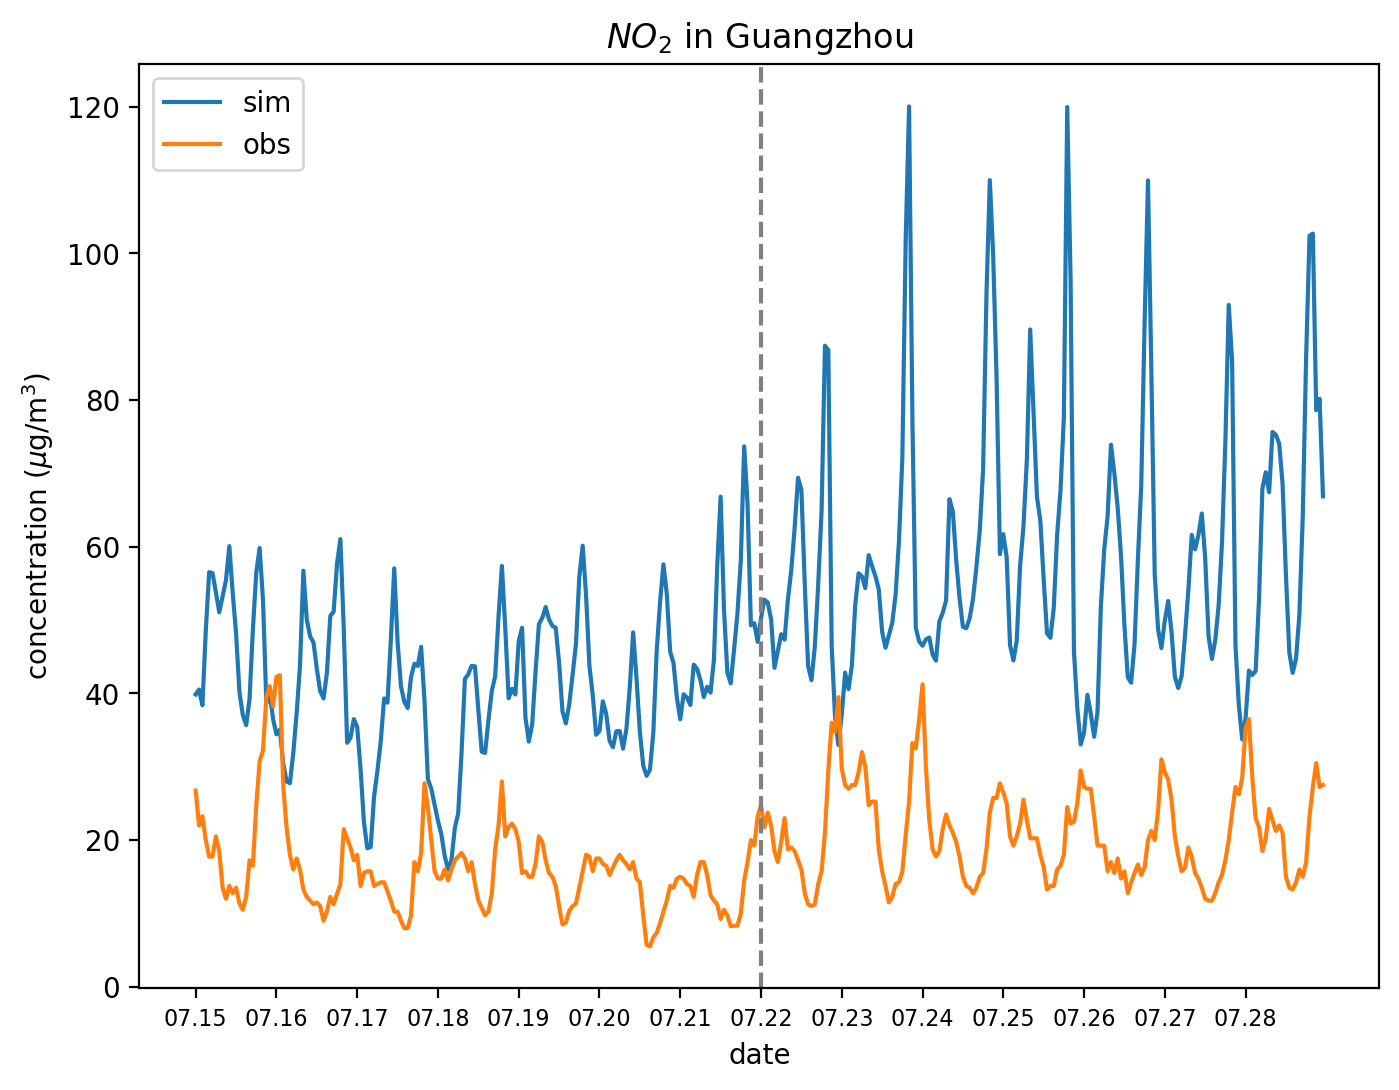

In [14]:
time=np.arange(0,336)

fig=plt.figure(figsize=(8,6),dpi=200)
ax=fig.subplots()
ax.plot(time,pre,label='sim')
ax.plot(time,obs,label='obs')
ax.legend(loc=2)
ax.set_title('$NO_2$ in Guangzhou')
ax.set_xlabel('date')
ax.set_ylabel('concentration ($\mu$g/m$^3$)')
ax.set_xticks(np.arange(0,336,24))
ax.set_xticklabels(['07.15','07.16','07.17','07.18','07.19','07.20','07.21','07.22','07.23','07.24','07.25','07.26','07.27','07.28'],size=8)
ax.axvline(x=168,color='gray',linestyle='--')
plt.show()

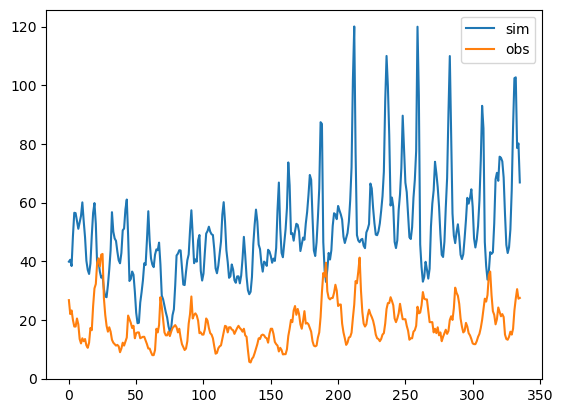

In [10]:
df_var=pd.DataFrame({'sim':pre,
                'obs':obs})
df_var.plot()
plt.show()

---

In [11]:
# 平均值
# print('obs_average=',np.nanmean(var_obs),'ug/m-3')
# print('sim_average=',np.nanmean(var),'ug/m-3')

# 相关系数
# df_var.corr().iloc[0,1]

# 平均偏差
# print(df_var.mad())
# print('sim-obs = ',df_var.mad()[0]-df_var.mad()[1])

# 均方根误差

# method 1
def get_mse(records_real, records_predict):
    """
    均方误差
    """
    if len(records_real) == len(records_predict):
        return sum([(x - y) ** 2 for x, y in zip(records_real, records_predict)]) / len(records_real)
    else:
        return None

def get_rmse(records_real, records_predict):
    """
    均方根误差
    """
    mse = get_mse(records_real, records_predict)
    if mse:
        return math.sqrt(mse)
    else:
        return None

# method 2
# MSE=np.square(np.subtract(O3_obs,O3)).mean()
# RMSE=math.sqrt(MSE)

# 标准化平均误差
def get_nme(observe,predict):
    if len(observe) == len(predict):
        return sum([abs(x - y) for x, y in zip(observe, predict)]) / sum(observe)
    else:
        return None

# 标准化平均偏差
def get_nmb(observe,predict):
    if len(observe) == len(predict):
        return sum([(x - y) for x, y in zip(observe, predict)]) / sum(observe)
    else:
        return None

In [13]:
eval_data=[['观测平均',np.nanmean(obs)],
            ['模拟平均',np.nanmean(pre)],
            ['相关系数',df_var.corr().iloc[0,1]],
            ['平均偏差',df_var.mad()[0]-df_var.mad()[1]],
            ['均方根误差',get_rmse(obs, pre)],
            ['标准化平均误差',get_nme(obs,pre)],
            ['标准化平均偏差',get_nmb(obs,pre)]]
df_eval=pd.DataFrame(eval_data,columns=['参数','值'])
print('variable = ','NO2')
df_eval

variable =  NO2


,参数,值
0,观测平均,18.454365
1,模拟平均,50.206992
2,相关系数,0.153116
3,平均偏差,6.856486
4,均方根误差,36.046602
5,标准化平均误差,1.728762
6,标准化平均偏差,-1.720603
